# Creating a high quality synthetic dataset with open models and a $10 budget

Large language models (LLMs) are awesome. Yet sometime they still struggle to grasp the subtleties of human communication, particularly when it comes to the nuanced understanding of day to day communication. Effective understanding requires a lot of skills. One such skill is the ability to distinguish statements which present observations (noticing) from statements which contain evaluations (judgments).

This skill is an integral part of [Nonviolent Communication (NVC)](https://en.wikipedia.org/wiki/Nonviolent_Communication), a form of communication aimed at building authentic understanding between people. I believe the technique and associated literature are a treasure trove of insights for building empathy through language.

In this post we will dive into how I used one exercise from a NVC book and $7 in [Together.ai](https://www.together.ai/) credits to generate, filter and refine a high quality text comprehension dataset of 1500 samples.

The final dataset is available on [Hugging Face](https://huggingface.co/datasets/thomasgauthier/observation_or_evaluation).

## Understanding human communication: Observations vs Evaluations

In his seminal book *Nonviolent Communication: A Language of Life*, NVC creator Marshall Rosenberg makes the case that the ability to distinguish between evaluations and observations is crucial for effective nonviolent communication. In his book, Rosenberg includes an exercise prompting readers to distinguish between both types of statements. Notice the use of the *prompting* here, that will be relevant later.  

> _Exercise 1_
> 
> OBSERVATION OR EVALUATION?
> 
> To determine your proficiency at discerning between observations and evaluations, complete the following exercise. Circle the number in front of each statement that is an observation only, with no evaluation mixed in.
> 
> 1.  “John was angry with me yesterday for no reason.”
> 2.  “Yesterday evening Nancy bit her fingernails while watching television.”
> 3.  “Sam didn’t ask for my opinion during the meeting.”
> 4.  “My father is a good man.”
> 5.  “Janice works too much.”
> 6.  “Henry is aggressive.”
> 7.  “Pam was first in line every day this week.”
> 8.  “My son often doesn’t brush his teeth.”
> 9.  “Luke told me I didn’t look good in yellow.”
> 10.  “My aunt complains when I talk with her.”
> 
> _Here are my responses for Exercise 1:_
> 
> 1.  If you circled this number, we’re not in agreement. I consider “for no reason” to be an evaluation. Furthermore, I consider it an evaluation to infer that John was angry. He might have been feeling hurt, scared, sad, or something else. Examples of observations without evaluation might be: “John told me he was angry,” or “John pounded his fist on the table.”
> 2.  If you circled this number, we’re in agreement that an observation was expressed without being mixed together with an evaluation.
> 3.  If you circled this number, we’re in agreement that an observation was expressed without being mixed together with an evaluation.
> 4.  If you circled this number, we’re not in agreement. I consider “good man” to be an evaluation. An observation without evaluation might be: “For the last twenty-five years, my father has given one-tenth of his salary to charity.”
> 5.  If you circled this number, we’re not in agreement. I consider “too much” to be an evaluation. An observation without evaluation might be: “Janice spent more than sixty hours at the office this week.”
> 6.  If you circled this number, we’re not in agreement. I consider “aggressive” to be an evaluation. An observation without evaluation might be: “Henry hit his sister when she switched the television channel.”
> 7.  If you circled this number, we’re in agreement that an observation was expressed without being mixed together with an evaluation.
> 8.  If you circled this number, we’re not in agreement. I consider “often” to be an evaluation. An observation without evaluation might be: “Twice this week my son didn’t brush his teeth before going to bed.”
> 9.  If you circled this number, we’re in agreement that an observation was expressed without being mixed together with an evaluation.
> 10.  If you circled this number, we’re not in agreement. I consider “complains” to be an evaluation. An observation without evaluation might be: “My aunt called me three times this week, and each time talked about people who treated her in ways she didn’t like.”

Reading this, I couldn't help but think that looked a whole lot like a NLP task.

## Testing large language models NVC abilities

Reading Rosenberg's book, I got curious about current large language models abilities to complete this exercise. How well can current AI systems, trained on vast datasets of human language, grasp the often nuanced distinction between factual observations and subjective evaluations? This demands the ability to delve deeper than surface interpretations, drawing inferences from context to identify implicit messages and understand the speaker's subjective perspective.  

Arguably, current models can already do this to some extent, but we would like to test this quantitatively. To do so we need a dataset to evaluate models against. As it stands, Rosenberg's book cannot bring us all the way there as it contains only 10 labeled statements (not to mention it is most likely part of the training set of a lot of models).

### Getting around data scarcity


Thankfully in 2024 we have access to a range of open-weight models from big and powerful to small and efficient. We can leverage that full array of generation capabilities to synthetically create a benchmark dataset for our task.  

We will use a larger model, assuming it will perform better initially, to generate evaluation prompts for smaller models.

While the generated data might not be 100% accurate, this isn't critical when aiming to assess relative performance. While our dataset might not be all that usefull in evaluating large models capabilities, it will still be useful to evaluate small models which make up a decent portion of the market. See, even if a smaller model benefits from occasional matches with incorrect labels in the test set, its overall lower accuracy compared to the larger model would still be evident. 

This approach might seem less than ideal but it scales well as we can generate new better test sets as better models are released over time. Improving the generation prompts could also lead to a baseline improvement without changing models. So even though it might be imperfect, this dataset will provide a solid foundation for future iterations.

To generate this first version of our dataset we will leverage a few low hanging fruits, mostly prompting techniques.

### Creating a good prompt

First we use few-shot prompting, so we present the model with a few classification examples before the statement we want to classify.

Second, using a simple [prompt](https://shareg.pt/TY5PQQk) we can ask ChatGPT to augment the classification with a rationale. This is similar to chain-of-thought prompting, the intuition is it will help with accuracy by allowing the model to expand more compute on the problem. Our few-shot examples will be the augmented examples.

With all this, we can then rework the exercise into a neat little text completion prompt.

Now we have a few-shot prompt to evaluate any model on this task. There's only one problem: the prompt allows us to evaluate any statement, but to make it into a benchmark we will need hundreds of statements with associated classification. Thankfully we can reuse our prompt to solve this problem.

### Llama 2 as Statement Generator

What if I told you we can use the evaluation prompt we crafted earlier to generate new statements? We simply truncate the prompt at 'Statement: ' and let the LLM complete.


Here we will use Llama 2 70B as it is a decently large model with little alignment bias and might provide more objective completions.

For this we will use my favorite cloud inference provider: Together. To save time we also leverage multithreading. As good measure, we save the prompts and generations to a sqlite database.

In [1]:
import os
from multiprocessing import Process, Queue, Event
import threading
import concurrent.futures
from queue import Queue, Empty
import traceback
import time
import sys
import requests
import random
import sqlite3
import json
import pandas as pd
pd.set_option('display.max_colwidth', None) # Don't truncate text in columns when displaying
from tqdm.notebook import tqdm

TOGETHER_API_KEY = os.environ.get('TOGETHER_API_KEY')
    
if TOGETHER_API_KEY is None:
    TOGETHER_API_KEY = input("Enter your Together API Key: ")
    
ENDPOINT_URL = 'https://api.together.xyz/v1/completions'

def make_seed_prompt():
    #GPT-4 augmented examples
    statements = ["""Statement: “John was angry with me yesterday for no reason.”
Reasoning: The statement suggests that John felt a certain emotion (anger) directed towards the speaker and adds the qualifier "for no reason". Emotions are subjective experiences, and we can't definitively know someone's emotion unless they express it. The phrase "for no reason" is a judgment because it interprets the cause of John's perceived emotion.
Classification: Evaluation
Pure observation alternative: “John told me he was angry,” or “John pounded his fist on the table.”""",
"""Statement: “Yesterday evening Nancy bit her fingernails while watching television.”
Reasoning: This statement is simply describing an action Nancy did at a specific time. There is no attached judgment or interpretation of why she did it or what it means about her character or state of mind.
Classification: Observation""",
"""Statement: “Sam didn’t ask for my opinion during the meeting.”
Reasoning: This is a factual statement about something Sam did not do during a meeting. It doesn't assign any emotion, motive, or judgment to Sam's actions.
Classification: Observation""",
"""Statement: “Working in the banking industry, I've found it difficult to maintain a balance between my professional life and personal life, especially with regards to my children.”
Reasoning: This statement combines several observations about the speaker's experience working in the banking industry and their personal struggles balancing work and family life. However, it also includes some evaluations like "difficult" and "especially with regards to my children."
Classification: Mixed
Pure observation alternative: “I work in the banking industry and I spend more time at the office than I do with my children.”""",
"""Statement: “My father is a good man.”
Reasoning: The term "good" is subjective. What constitutes a "good man" can vary from person to person. This statement is expressing a personal judgment or belief about the father's character rather than a factual observation.
Classification: Evaluation
Nonviolent alternative: “For the last twenty-five years, my father has given one-tenth of his salary to charity.”""",
"""Statement: “Janice works too much.”
Reasoning: The phrase "too much" is a judgment that implies there is an appropriate or normal amount of work, and Janice exceeds that. It's not a simple recounting of facts but an interpretation of her work habits.
Classification: Evaluation
Pure observation alternative: “Janice spent more than sixty hours at the office this week.”""",
"""Statement: “Henry is aggressive.”
Reasoning: Labeling Henry as "aggressive" is a judgment. "Aggressive" is an interpretive term that assigns a character trait to Henry based on behaviors or actions that aren't specified in this statement.
Classification: Evaluation
Pure observation alternative: “Henry hit his sister when she switched the television channel.”""",
"""Statement: “Pam was first in line every day this week.”
Reasoning: This statement simply states a repeated action Pam took on specific days. There's no interpretation about why she was first in line or what it might mean about her character.
Classification: Observation""",
"""Statement: “My son often doesn’t brush his teeth.”
Reasoning: The term "often" is a judgment that implies a frequency comparison to what is considered normal or acceptable. The statement isn't just stating times when the son didn't brush his teeth but is implying he neglects this action more than he should.
Classification: Evaluation
Pure observation alternative: “Twice this week my son didn’t brush his teeth before going to bed.”""",
"""Statement: “Luke told me I didn’t look good in yellow.”
Reasoning: This statement recounts a specific thing Luke said to the speaker. While Luke's statement was evaluative, the speaker is merely stating a fact about what Luke expressed, without adding their own judgment or interpretation.
Classification: Observation"""]

    random.shuffle(statements) # Let's shuffle the few shot ordering, hopefully this will give us more varied outputs

    concatenated = "\n\n".join(statements)
    
    return """OBSERVATION OR EVALUATION?

In the context of Nonviolent Communication (NVC), it's crucial to distinguish between observations and evaluations. Observations are neutral descriptions of what one perceives, devoid of personal judgments or interpretations. In contrast, evaluations contain personal judgments or interpretations of situations. Your task is to review the provided statements and identify which ones are pure observations without any evaluations mixed in. By mastering this distinction, you can communicate more effectively, minimizing misunderstandings and conflicts.

To determine your proficiency at discerning between observations and evaluations, complete the following exercise.

""" + concatenated + '\n\n' + 'Statement:'

# Let's define a class that will allow us to call a generate function many times in parallel
class Generator:
    def __init__(self, max_workers, generate_function, arguments_list):
        self.task_queue = Queue()
        self.results_queue = Queue()
        self.workers = []
        self.max_workers = max_workers
        self.generate_function = generate_function
        self.arguments_list = arguments_list
        self.stop_signal_received = False

    def worker(self):
        while not self.stop_signal_received:
            try:
                arg = self.task_queue.get(timeout=1)
                if arg is None:  # Stop signal
                    break
                try:
                    result = self.generate_function(arg)
                    self.results_queue.put(result)
                except Exception as e:
                    traceback.print_exc()
                finally:
                    self.task_queue.task_done()
            except Empty:
                continue

    def start_workers(self):
        for _ in range(self.max_workers):
            worker = threading.Thread(target=self.worker)
            worker.start()
            self.workers.append(worker)

    def stop_workers(self):
        self.stop_signal_received = True
        for _ in self.workers:
            self.task_queue.put(None)  # Send stop signal to all workers
        for worker in self.workers:
            worker.join()

    def __iter__(self):
        self.stop_signal_received = False  # Reset stop signal in case of reuse
        try:
            # Enqueue all tasks
            for arg in self.arguments_list:
                self.task_queue.put(arg)
            # Start worker threads
            self.start_workers()
        except KeyboardInterrupt:
            print("KeyboardInterrupt detected, stopping workers...")
            self.stop_workers()
            raise
        return self

    def __next__(self):
        if self.stop_signal_received and self.results_queue.empty():
            raise StopIteration
        try:
            result = self.results_queue.get(timeout=120)
            return result
        except Empty:
            self.stop_signal_received = True  # Signal to stop if no results are available
            self.stop_workers()
            raise StopIteration

def generate_statement(_, max_retries=10):
    prompt = make_seed_prompt()
    generation_params = {
        "model": "togethercomputer/llama-2-70b",
        "max_tokens": 512,
        "temperature": 0.7,
        "top_p": 0.7,
        "top_k": 50,
        "stop": "\n\n",
        "repetition_penalty": 1,
    }

    retries = 0
    while retries < max_retries:
        try:
            res = requests.post(ENDPOINT_URL, json={
                **generation_params,
                "prompt": prompt,
            }, headers={
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
            })

            if res.status_code == 200:
                return prompt, res.json()['choices'][0]['text'], generation_params
            else:
                error_message = res.text
                print(f"Attempt {retries + 1} failed with status code {res.status_code}. Error: {error_message}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}. Retrying...")

        retries += 1
        time.sleep(1)  # Sleep for a bit before retrying to avoid overwhelming the server

    return None



def create_statement_generation_table():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS statement_generation (
            id INTEGER PRIMARY KEY,
            prompt TEXT,
            generation TEXT,
            statement TEXT,
            generation_params json
        )
    ''')
    conn.commit()
    conn.close()

def insert_generated_statement(prompt, generation, statement, generation_params):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        INSERT INTO statement_generation (prompt, generation, statement, generation_params)
        VALUES (?, ?, ?, ?)
    ''', (prompt, generation, statement, json.dumps(generation_params)))
    conn.commit()
    conn.close()

def table_as_dataframe(table):
    conn = sqlite3.connect('results.sqlite')
    query = f'SELECT * FROM {table}'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

Enter your Together API Key:  


In [2]:
%%time

create_statement_generation_table()

n_samples = 1000

arguments_list = [float("nan")] * n_samples
generator = Generator(max_workers=20, generate_function=generate_statement, arguments_list=arguments_list)

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        prompt, generation, generation_params = result
        open_curly_quote = generation.find('“')
        close_curly_quote = generation.find('”')
    
        if open_curly_quote >= 0 and close_curly_quote >= 0:
            statement = generation[open_curly_quote+1:close_curly_quote]
            insert_generated_statement(prompt, generation, statement, generation_params)

  100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<?, ?it/s]

CPU times: user 36.9 s, sys: 1.53 s, total: 38.4 s
Wall time: 5min 47s


let's look at some generated statements

In [3]:
table_as_dataframe('statement_generation').head()

,id,prompt,generation,statement,generation_params
0,1,OBSERVATION OR EVALUATION?\n\nIn the context o...,“I’m worried about the project.”\nReasoning: T...,I’m worried about the project.,"{""model"": ""togethercomputer/llama-2-70b"", ""max..."
1,2,OBSERVATION OR EVALUATION?\n\nIn the context o...,“I feel uncomfortable when I’m in a room with ...,I feel uncomfortable when I’m in a room with m...,"{""model"": ""togethercomputer/llama-2-70b"", ""max..."
2,3,OBSERVATION OR EVALUATION?\n\nIn the context o...,“I don’t like my boss.”\nReasoning: This stat...,I don’t like my boss.,"{""model"": ""togethercomputer/llama-2-70b"", ""max..."
3,4,OBSERVATION OR EVALUATION?\n\nIn the context o...,“The weather was awful today.”\nReasoning: Th...,The weather was awful today.,"{""model"": ""togethercomputer/llama-2-70b"", ""max..."
4,5,OBSERVATION OR EVALUATION?\n\nIn the context o...,“The weather is bad today.”\nReasoning: This ...,The weather is bad today.,"{""model"": ""togethercomputer/llama-2-70b"", ""max..."


Well... our generations don't seem to have a lot of variety, let's plot their similarity using the `all-MiniLM-L6-v2` sentence embedding model.

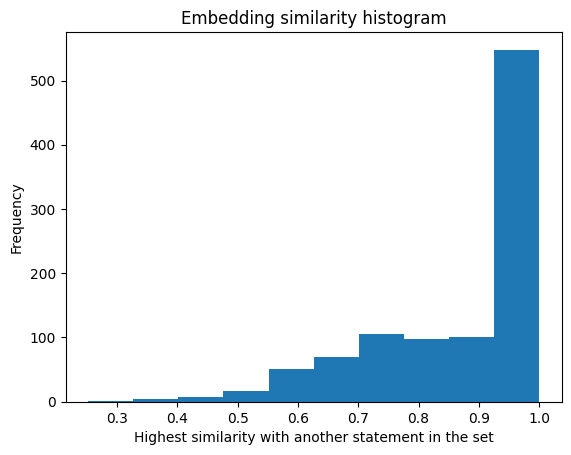

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def fetch_all_statements():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('SELECT statement FROM statement_generation')
    all_statements = [row[0] for row in c.fetchall()]
    conn.close()
    return all_statements

statements = fetch_all_statements()
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each string in the DataFrame
embeddings = model.encode(statements)

# Calculate cosine similarity
cosine_sim = cosine_similarity(embeddings)

# Exclude self-comparison
np.fill_diagonal(cosine_sim, -1)

highest_cosine_similarity_by_embedding = np.max(cosine_sim, axis=1)

plt.hist(highest_cosine_similarity_by_embedding, bins=10)
plt.xlabel('Highest similarity with another statement in the set')
plt.ylabel('Frequency')
plt.title('Embedding similarity histogram')
plt.show()

That's a lot of similar statements... It seems the Llama 2 70B model is exhibiting some sort of [mode collapse](https://www.lesswrong.com/posts/t9svvNPNmFf5Qa3TA/mysteries-of-mode-collapse) here.

To make sure our statements have sufficient variety let's bring in some real world data. What if we sourced statements from TV scripts? Given the nature of our task, let's aim for material that touches on every day sensibilities and showcases a lot of complex interpersonal dynamics.

## Getting Around Mode Collapse with TV Scripts


Looking around the internet, I found [this dataset](https://www.kaggle.com/datasets/luongleanstocode/seinfeld-text-corpus) on Kaggle that contains all the Seinfeld episode scripts in a single .txt file.

Let's parse the file into scenes and dialogues.

In [5]:
import re

scenes = []

with open('corpus.txt', 'r') as f:
    current_scene = None
    for line in f:
        line = line.strip()
        
        if  (line.startswith('[') and line.endswith(']')) or ('INT.' in line or 'EXT.' in line):
            if not current_scene is None:
                scenes.append(current_scene)
            current_scene = {}
            current_scene['location'] = line
            current_scene['text'] = line
        elif not current_scene is None:
            current_scene['text'] += '\n' + line  

def flatten(arr):
    flattened = []
    for item in arr:
        if isinstance(item, list):
            flattened.extend(flatten(item))
        else:
            flattened.append(item)
    return flattened

def extract_dialogues(strings):
    extracted_parts = []
    
    for string in strings:
        if re.match(r"^[A-Z\s]+:", string): # Match "CHARACTER NAME: ..." 
            extracted_part = string.split(':', 1)[1].strip()
            extracted_parts.append(extracted_part)
    
    return extracted_parts

dialogues = flatten([extract_dialogues(scene['text'].split('\n')) for scene in scenes])

Now, let's see if we can use a zero-shot classification model based on BERT to identify dialogues that serve as clear examples of observations or evaluations, while filtering out onomatopoeia, interjections and other irrelevant utterances.

In [6]:
import torch
from tqdm import tqdm
from transformers import pipeline

def create_classification_table():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS dialogue_bert_classification (
            id INTEGER PRIMARY KEY,
            dialogue TEXT,
            conversation_score REAL,
            statement_score REAL,
            ratio REAL
        )
    ''')
    conn.commit()
    conn.close()


def insert_classification_result(dialogue, conversation_score, statement_score, ratio):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        INSERT INTO dialogue_bert_classification (dialogue, conversation_score, statement_score, ratio)
        VALUES (?, ?, ?, ?)
    ''', (dialogue, conversation_score, statement_score, ratio))
    conn.commit()
    conn.close()


def check_if_classified(dialogue):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    # Prepare the query, using parameter substitution to avoid SQL injection
    c.execute('SELECT id FROM dialogue_bert_classification WHERE dialogue = ?', (dialogue,))
    result = c.fetchone()  # Fetch the first row of results
    conn.close()
    return result is not None  # Return True if a result was found, otherwise False




device = 'cuda' if torch.cuda.is_available() else 'cpu'

classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli", device=0)

# Define the batch size
batch_size = 32  # You can adjust this based on your memory constraints

# Function to divide the dataset into batches
def divide_into_batches(data, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i + batch_size]

# Split the dataset into batches
batches = list(divide_into_batches(dialogues[0:100], batch_size))

candidate_labels = ["conversation", "statement"]

conversation_scores = []
statement_scores = []

create_classification_table()

# Process each batch
for batch in tqdm(batches):
    for i, dialogue in enumerate(batch):
        if check_if_classified(dialogue):
            continue

        output = classifier([dialogue], candidate_labels, multi_label=False)[0]
        conversation_score = output['scores'][0]
        statement_score = output['scores'][1]
        ratio = statement_score / conversation_score

        insert_classification_result(dialogue, conversation_score, statement_score, ratio)
        
df = table_as_dataframe('dialogue_bert_classification')
df['ratio'] = df.apply(lambda row: row['statement_score'] / row['conversation_score'], axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.01s/it]


Let's look at the dialogues that the model classified as statements (or with roughly equal weighting for *statement* and *conversation*)  
For that let's look at the weighting distribution (expressed as ratio of statement score over conversation score)

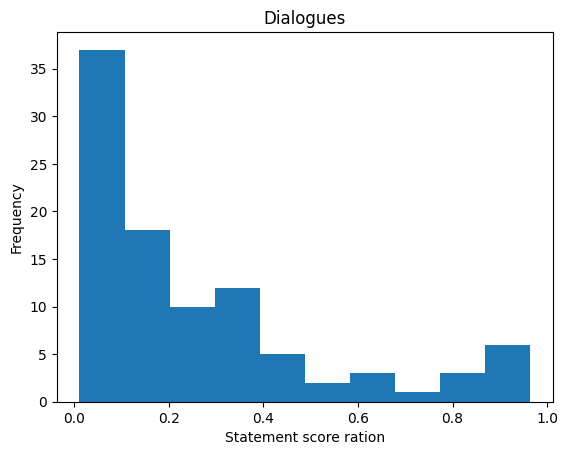

In [7]:
import matplotlib.pyplot as plt

plt.hist(df['ratio'], bins=10)
plt.xlabel('Statement score ratio')
plt.ylabel('Frequency')
plt.title('Dialogues')
plt.show()

0.8 maybe seems like a good treshold

In [8]:
df[df['ratio'] > 0.8].sort_values(by='ratio')[['dialogue', 'ratio']]

,dialogue,ratio
54,I'm not gonna watch you do laundry.,0.821589
59,Jerry? I have to tell you something. This is the dullest moment I've ever experienced.,0.871188
66,"Yeah, but how could you be so sure?",0.876894
93,"You know, I almost wound up going to that game.",0.893139
12,Trust me George. No one has any interest in seeing you on caffeine.,0.923207
34,"No...no...no, I hate to tell you this. You're not gonna see this woman.",0.937720
11,"Can you relax, it's a cup of coffee. Claire is a professional waitress.",0.964591


These examples aren't really suitable for our purpose. A lot of them are clearly dialogue excerpts lacking context, they're not the kind of textbook-style self-contained statements that we're looking for.

What if instead of using the dialogues directly we fed the scripts to a LLM and asked it to create statements inspired by it?

To get the results we are looking for we will use a convenient little trick. We use the [chat templates](https://huggingface.co/docs/transformers/chat_templating) feature of the Hugging Face tokenizer library to feed the model both our user prompt and an affirmation by the model. We basically prefix the model's answer with a few words of acknowledgment ("*Understood. I will now do [description of task]*"). The way I understand it, this basically helps the attention layer make associations between the AI answer and user instruction, this in turn seems to generate more relevant answers. If you want the model to remember a particular step you can add it to this part. ("*I will do [...] while making sure that [important constraint  to remember]*"). It can also help with getting a specific format out of the model ("*Here are the [things you asked for] in json format : &#123;*")

We use this togeter with the `apply_chat_template` method of the tokenizer to format the prompt based on our messages.
See the animation below.

![image](img/impersonated_acknowledgment.webp)
---
Impersonated acknowledgment prompting with ChatML, red is typed in by a user, blue is language model completion

With this, we are ready to start generating statements based on the Seinfeld scripts.

In [9]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('NousResearch/Nous-Hermes-2-Mixtral-8x7B-SFT', use_fast=True)

# our prompt only generates evaluations, we do this because when asking the model for an observation it seems to always start with "I notice", resulting in non natural sounding statements
# instead we will generate only evaluations as there are more naturally occurring in our data
# to counteract the imbalance we will later derive observation statements from the evaluations

def make_prompt(scene):
    prompt = f"""We are working on  a textbook.

Here is an excerpt

```
To determine your proficiency at discerning between observations and evaluations, complete the following exercise.

“John was angry with me yesterday for no reason.”
It is an evaluation

“Yesterday evening Nancy bit her fingernails while watching television.”
It is an observation

“Sam didn’t ask for my opinion during the meeting.”
It is an observation

“My father is a good man.”
It is an evaluation

“Janice works too much.”
It is an evaluation

“Henry is aggressive.”
It is an evaluation

“Pam was first in line every day this week.”
It is an observation

“My son often doesn’t brush his teeth.”
It is an evaluation

“Luke told me I didn’t look good in yellow.”
It is an observation
```


We want to create new examples and statements.

Read this as inspiration

```
{scene}
```


Roleplay as one of the characters and make a evaluation statement"""
    
    return tokenizer.apply_chat_template([{
                            "content": prompt,
                            "role": "user"
                        }], tokenize=False, add_generation_prompt=True) + 'Understood. I will write a new statement for your NVC textbook by roleplaying as one of the characters in this scene.\nI will roleplay as' #[AI completes here] #impersonated acknowledgment

In [10]:
def create_scene_statements_table():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS scene_statements (
            id INTEGER PRIMARY KEY,
            scene TEXT,
            prompt TEXT,
            generation TEXT,
            generation_params json
        )
    ''')
    conn.commit()
    conn.close()

def insert_scene_statement(scene, prompt, generation, generation_params):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    
    # Check if the scene with the same prompt already exists
    c.execute('''
        SELECT COUNT(*) FROM scene_statements WHERE scene = ? AND prompt = ?
    ''', (scene, prompt))
    exists = c.fetchone()[0] > 0
    
    # If it doesn't exist, insert the new row
    if not exists:
        c.execute('''
            INSERT INTO scene_statements (scene, prompt, generation, generation_params)
            VALUES (?, ?, ?, ?)
        ''', (scene, prompt, generation, json.dumps(generation_params)))
        conn.commit()
    else:
        print("Entry already exists for scene and prompt, skipping insert.")
    
    conn.close()

def get_generated_statement_for_scene_prompt(prompt):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    # Query to find an existing generation for the given prompt
    c.execute('''
        SELECT generation FROM scene_statements WHERE prompt = ?
    ''', (prompt,))
    result = c.fetchone()
    conn.close()
    return result[0] if result else None
    
def generate_statement_from_scene(scene, max_retries=10):
    generation_params = {
        "model": "NousResearch/Nous-Hermes-2-Mixtral-8x7B-SFT",  # We use SFT version and not DPO because it is allegedly better at creative uses
        "max_tokens": 512,
        "temperature": 0.7,
        "top_p": 0.7,
        "top_k": 50,
        "stop": [
            "<|im_end|>",
            "<|im_start|>"
        ],
        "repetition_penalty": 1,
    }

    prompt = make_prompt(scene)

    if len(tokenizer.encode(prompt)) > 32768:
        return None # Skip prompts that are too long
        
    
    existing_generation = get_generated_statement_for_scene_prompt(prompt)

    if existing_generation is not None:
        print("Found existing generation for prompt")
        return None

    retries = 0
    while retries < max_retries:
        try:
            res = requests.post(ENDPOINT_URL, json={
                **generation_params,
                "prompt": prompt,
            }, headers={
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
            })

            if res.status_code == 200:
                return scene, prompt, res.json()['choices'][0]['text'], generation_params
            else:
                error_message = res.text
                print(f"Attempt {retries + 1} failed with status code {res.status_code}. Error: {error_message}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}. Retrying...")

        retries += 1
        time.sleep(1)  # Sleep for a bit before retrying to avoid overwhelming the server

    return None
    
scene_texts = [scene['text'] for scene in scenes][0:30]

arguments_list = scene_texts
generator = Generator(max_workers=20, generate_function=generate_statement_from_scene, arguments_list=arguments_list)

create_scene_statements_table()

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        scene, prompt, generation, generation_params = result
        insert_scene_statement(scene, prompt, generation, generation_params)

100%|█████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]

Let's look at the newly generated statements:

In [11]:
table_as_dataframe('scene_statements')[['generation']]

,generation
0,"Elaine and make an evaluation statement.\n""Jerry, your constant interruptions during our conversations are really frustrating."""
1,"Jerry and make an evaluation statement.\nJerry: ""Performing on stage is one of the most exhilarating experiences I've ever had."""
2,"Helen and make an evaluation statement.\n""Jerry, you're always so worried about what other people think. It's exhausting to watch."""
3,"Jerry and make an evaluation statement.\n""Jerry: (thinking) Vanessa is the most captivating woman I've ever met."""
4,"Helen, Jerry's mother.\n""I think Jerry should just ask Elaine for the number instead of waiting for the other woman in the lobby."""
...,...
3643,"Jerry Seinfeld. Here's the statement:\n""Jerry Seinfeld felt embarrassed when he had to wear the puffy shirt on the Today Show.""\nThis statement is an evaluation because it expresses Jerry's emotional response to the situation."
3644,"Elaine and make an evaluation statement.\nElaine: ""The Soup Nazi's soup is the best I've ever tasted."""
3645,"Jane Wells.\nStatement: ""The endless parade of witnesses who have come forth so enthusiastically to testify against these four seemingly ordinary people has left the courtroom and everyone who has attended this trial in a state of shock and disbelief."""
3646,"Babu Bhatt and make an evaluation statement.\n""Jerry and Elaine's constant mocking of me and my restaurant has deeply hurt my feelings and damaged my reputation. They are not good people."""


That looks good, it just need a big of cleaning to remove extra text. We could try and conjure some regex magic but instead we will just prompt the model again and ask it to clean the string the way we want. And while we are at it we will also ask the LLM to change the names in the statement so we don't end up with a dataset biased towards people named 'Jerry', 'George' or 'Elaine'. To ensure a nice distribution of names we will provide the LLM with a random list of names to choose from. The `faker` library can help with that.

In [12]:
!pip install faker

DEPRECATION: omegaconf 2.0.6 has a non-standard dependency specifier PyYAML>=5.1.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of omegaconf or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [13]:
import random
from transformers import AutoTokenizer
from faker import Faker

fake = Faker()

tokenizer = AutoTokenizer.from_pretrained('teknium/OpenHermes-2.5-Mistral-7B', use_fast=True)

nl = '\n'

def clean_prompt(input):
    return f"""Rewrite what is verbally stated in the input given by the user, excluding any preambles or introductions that are not part of the direct speech. The output should be enclosed in curly quotation marks.


examples:
---
USER:

input
```
Elaine. Statement: "Elaine's ability to adapt and maintain her composure in unfamiliar situations is truly impressive."
```

names_to_choose_from
```
Alicia
Nancy
Robertson
Gonzales
Vega
```

ASSISTANT: There was a stray "Elaine" leading the input, and also the string "Statement. :" I removed both.
In addition, within the statement I found the following name : Elaine.
I made sure to replace those names with ones you gave me.

Cleaned statement : “Mckay's ability to adapt and maintain his composure in unfamiliar situations is truly impressive.”
USER:

input
```
George and make an evaluation statement.
"I think the new scoreboard will make a significant impact on the fans' experience at the games."
```

names_to_choose_from
```
Ronald
Mckay
Emily
Vargas
Michelle
```

Output:
ASSISTANT: The input contains a statement but has a preamble "George and make an evaluation statement.\n". I made sure to remove it.

Cleaned statement : “I think the new scoreboard will make a significant impact on the fans' experience at the games”
USER:

input:
```
Jerry and make an evaluation statement.
Statement: "It's ridiculous that we have to come to this party and pretend to be happy for Carol and Larry when we're actually miserable because of the apartment situation."
```

names_to_choose_from
```
Justin
Smith
Harrington
Graves
Carr
Sanchez
Page
Randall
```

ASSISTANT: The input contains a statement but has a preamble "Jerry and make an evaluation statement.". I made sure to remove it.
In addition, within the statement I found the following name: Carol, Larry.
I made sure to replace those names with ones you gave me.

Cleaned statement : “It's ridiculous that we have to come to this party and pretend to be happy for Justin and Randall when we're actually miserable because of the apartment situation.”

USER:

input
```
{input}
```

names_to_choose_from
```
{nl.join([random.choice([fake.first_name(), fake.last_name()]) for e in range(35)]) # in the list of names we randomly choose either a first name or a last name to ensure even more variety}
```"""

In [14]:
def create_table_for_clean_statements():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS clean_statements (
            id INTEGER PRIMARY KEY,
            initial_statement TEXT UNIQUE,
            prompt TEXT UNIQUE,
            generation TEXT,
            generation_params json
        )
    ''')
    conn.commit()
    conn.close()

def insert_clean_statement(initial_statement, prompt, generation, generation_params):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    
    try:
        c.execute('''
            INSERT INTO clean_statements (initial_statement, prompt, generation, generation_params)
            VALUES (?, ?, ?, ?)
        ''', (initial_statement, prompt, generation, json.dumps(generation_params)))
        conn.commit()
    except sqlite3.IntegrityError:
        print("Entry already exists for prompt, skipping insert.")
    
    conn.close()

def get_clean_generation_for_statement_prompt(prompt):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        SELECT generation FROM clean_statements WHERE prompt = ?
    ''', (prompt,))
    result = c.fetchone()
    conn.close()
    return result[0] if result else None

def clean_and_generate(statement, max_retries=10):
    generation_params = {
        "model": "teknium/OpenHermes-2p5-Mistral-7B", # A 7B model will do the job here
        "max_tokens": 512,
        "temperature": 0.5,
        "top_p": 0.4,
        "top_k": 50,
        "stop": [
            "<|end_of_turn|>",
            "</s>",
            "”"
        ],
        "repetition_penalty": 1,
    }
    
    prompt = tokenizer.apply_chat_template([
         {
             "role": "user",
             "content": clean_prompt(statement) }], tokenize=False, add_generation_prompt=True)

    existing_generation = get_clean_generation_for_statement_prompt(prompt)

    if existing_generation is not None:
        print("Found existing generation for prompt")
        return None

    retries = 0
    while retries < max_retries:
        try:
            res = requests.post(ENDPOINT_URL, json={
                **generation_params,
                "prompt": prompt,
            }, headers={
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
            })

            if res.status_code == 200:
                return statement, prompt, res.json()['choices'][0]['text'], generation_params
            else:
                error_message = res.text
                print(f"Attempt {retries + 1} failed with status code {res.status_code}. Error: {error_message}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}. Retrying...")

        retries += 1
        time.sleep(1)  # Sleep for a bit before retrying to avoid overwhelming the server

    return None


def fetch_generations_from_scene_statements():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        SELECT generation FROM scene_statements
    ''')
    generations = c.fetchall()
    conn.close()

    return [generation[0] for generation in generations]

arguments_list = fetch_generations_from_scene_statements()

generator = Generator(max_workers=20, generate_function=clean_and_generate, arguments_list=arguments_list)

create_table_for_clean_statements()

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        initial_statement, prompt, generation, generation_params = result
        insert_clean_statement(initial_statement, prompt, generation, generation_params)

  100%|█████████████████████████████████████████████████████████████████████████████████████| 3648/3648 [00:00<?, ?it/s]

In [15]:
table_as_dataframe('clean_statements')[['generation']].sample(5)

,generation
1577,"The input contains a statement but has a preamble ""George and make an evaluation statement."". I made sure to remove it.\nIn addition, within the statement I found the following names: Jerry, Elaine, and my father.\nI made sure to replace those names with ones you gave me.\n\nCleaned statement : “It's disappointing that Danielle and Brett didn't take the time to say hello to my father."
1715,"The input contains a statement but has a preamble ""Elaine and make an evaluation statement:"". I made sure to remove it.\nIn addition, within the statement I found the following name: Landis.\nI made sure to replace that name with ones you gave me.\n\nCleaned statement : “It's heartbreaking to see James so devastated about his injury. I can't imagine how difficult it must be for him to face the possibility of not being able to play tennis again."
1678,"The input contains a statement but has a preamble ""Jerry."". I made sure to remove it.\nIn addition, within the statement I found the following name: Jerry.\nI made sure to replace that name with ones you gave me.\n\nCleaned statement : “David believes that the specials are a waste of time and effort for both the waitress and the customer, as they are not special enough to be included on the regular menu."
1001,"The input contains a statement but has a preamble ""Jerry and make an evaluation statement."". I made sure to remove it.\nIn addition, within the statement I found the following name: Elaine.\nI made sure to replace that name with ones you gave me.\n\nCleaned statement : “I think Elizabeth is always in a rush and doesn't value our time together."
1857,"The input contains a statement but has a preamble ""Jerry and make an evaluation statement."". I made sure to remove it.\nIn addition, within the statement I found the following name: Newman.\nI made sure to replace that name with ones you gave me.\n\nCleaned statement : “Nathan, always leaving his Chunky wrappers in my apartment. He's such a slob!"


Looking good! Let's extract the cleaned statements

In [16]:
df = table_as_dataframe('clean_statements')
df = df[df['generation'].str.contains("“")] # heuristic to keep good results

In [17]:
def extract_statement_from_response(response):
    quote_idx = response.rfind("“") # We use rfind to make sure to get the last quote statement

    return response[quote_idx+1:]

df['cleaned_statement'] = df['generation'].apply(extract_statement_from_response)
df = df[df['cleaned_statement'] != ''] # Filter for empty statements

df[['cleaned_statement']]

,cleaned_statement
0,Performing on stage is one of the most exhilarating experiences I've ever had.
1,Vanessa is the most captivating woman I've ever met.
2,"Heather, you're always so worried about what other people think. It's exhausting to watch."
3,"Maria, your constant interruptions during our conversations are really frustrating."
4,You're always barging in unannounced and making a mess. It's really inconsiderate.
...,...
3541,Moore felt embarrassed when he had to wear the puffy shirt on the Today Show.
3542,"Evans may have been a good employee, but his lack of knowledge about baseball was quite concerning."
3543,Melanie and Dana's constant mocking of me and my restaurant has deeply hurt my feelings and damaged my reputation. They are not good people.
3544,"I can't believe we got caught and are now facing criminal charges. This whole situation is a complete disaster, and I can't help but feel like we're all going to pay the price for our reckless behavior."


That seems like what we wanted!

Now let’s deduplicate using embedding similarity.

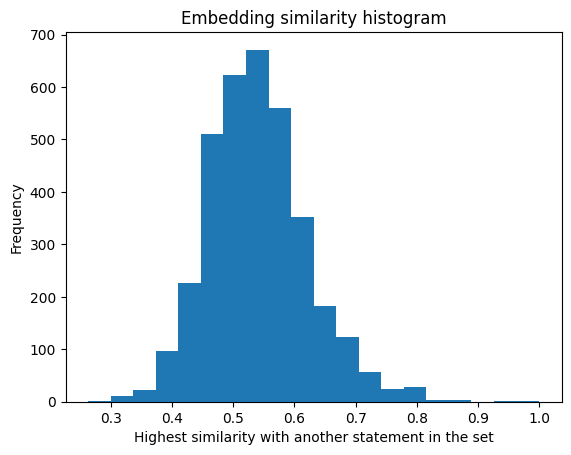

In [18]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


statements = df['cleaned_statement'].to_list()
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for each statement
embeddings = model.encode(statements)

# Calculate cosine similarity
cosine_sim = cosine_similarity(embeddings)

# Exclude self-comparison
np.fill_diagonal(cosine_sim, -1)

# Find the index of the most similar statement for each statement
most_similar_indices = np.argmax(cosine_sim, axis=1)

# Calculate the highest cosine similarity score for each statement
highest_cosine_similarity_scores = np.max(cosine_sim, axis=1)

# Retrieve the most similar statement for each statement using the indices
most_similar_statements = [statements[index] for index in most_similar_indices]

# Create a DataFrame
df = pd.DataFrame({
    'statement': statements,
    'most_similar_statement': most_similar_statements,
    'highest_cosine_similarity_by_embedding': highest_cosine_similarity_scores
})

# Plotting
plt.hist(df['highest_cosine_similarity_by_embedding'], bins=20)  # Adjust the number of bins as needed
plt.xlabel('Highest similarity with another statement in the set')
plt.ylabel('Frequency')
plt.title('Embedding similarity histogram')
plt.show()

That's a normal distribution if I've ever seen one. Mode collapse avoided!

Let's still look at the similar examples to find a good treshold for filtering

In [19]:
df[df['highest_cosine_similarity_by_embedding'] < 0.8].sort_values(by='highest_cosine_similarity_by_embedding', ascending=False)

,statement,most_similar_statement,highest_cosine_similarity_by_embedding
1594,I think Michael is a bit too harsh with his comments towards Christopher. It's not very welcoming.,I think Michael is overthinking this whole Christopher situation.,0.798949
984,I think Michael is overthinking this whole Christopher situation.,I think Michael is a bit too harsh with his comments towards Christopher. It's not very welcoming.,0.798949
34,I think the check at the end of the meal system is flawed. It ruins the dining experience and leaves people feeling stressed and unhappy.,I can't believe how much people complain about the check at the end of the meal. It's like they forget they just ate a huge meal and now they have to pay for it.,0.797722
254,I can't believe how much people complain about the check at the end of the meal. It's like they forget they just ate a huge meal and now they have to pay for it.,I think the check at the end of the meal system is flawed. It ruins the dining experience and leaves people feeling stressed and unhappy.,0.797722
2898,"I feel overwhelmed by the amount of work I have to do. It's like I'm drowning in a sea of tasks, and I can't seem to catch a break.",I feel overwhelmed by the amount of work I have to complete before the deadline.,0.797156
...,...,...,...
838,The Falconer,My car! My caaaaarrrr!,0.326148
3331,Bacterial Meningitis is the most challenging disease to portray convincingly.,"Kramer: I must say, Dr. Hughes, you have a remarkable ability to diagnose patients with just a glance. It's truly impressive.",0.315971
2303,I'm sure it'll turn up.,"Elaine: I think the Randolph's engagement party is going to be a huge success, with everyone bringing thoughtful gifts.",0.305895
2832,I don't know anything about that.,I think we can do a little better than that.,0.277915


0.8 cosine similarity seems like a good threshold for removing duplicates. Our data is starting to look good!

In [20]:
kept = df[df['highest_cosine_similarity_by_embedding'] < 0.8]

Now let's inspect our cleaned samples to make sure they are indeed "clean"

In [21]:
kept.sample(10)

,statement,most_similar_statement,highest_cosine_similarity_by_embedding
2180,"I am deeply saddened by the loss of Derek, but we must move forward and focus on the business at hand.","It's frustrating to see Derek struggling with his relationship with Lisa, but I can't help but find it entertaining.",0.521388
2010,"I can't believe you had to run away from those dogs, Joanna. It's just not safe for you to be walking around in this neighborhood.",Felicia: I can't believe how loud those dogs are! It's like they're trying to wake the entire neighborhood!,0.540056
2924,I feel frustrated and disappointed when Benson took away my desk without considering how much I valued that space.,I believe that House's reaction to the lack of space under the desk was overly dramatic and unnecessary.,0.550225
2318,"I can't believe how lucky I am today. First, the wedding is delayed until June, which feels like a stay of execution. Then, I find out that Mason's best friend, Jasmine, broke up with her boyfriend. This is a perfect opportunity for me to set up a date with Jasmine and enjoy some of the benefits of being in a relationship without actually being married.","I can't believe you missed the wedding, Tamara. You always manage to be late for the important events in our lives.",0.574179
1137,I find it disrespectful that Brian keeps using thin tape on my car's dashboard. It shows a lack of consideration for my preferences.,"The Gonzalez seems to be overly concerned about the lipstick on his dashboard, which is a minor issue compared to the condom found in his car.",0.483860
1841,"Jake, I must say, you have the most peculiar dental habits I've ever seen. It's almost as if you enjoy coming to the dentist!","Jerry's evaluation of the electric toothbrush - The Ori-dent is unbelievable. Every time you use it, you feel like you just came from the dentist!",0.562710
66,"Jerry's reaction to the eulogist's mention of Michael's pony shows that he is uncomfortable with the idea of expressing emotions, especially during a somber event like a funeral.","Jerry's Evaluation Statement: Despite the eulogy's attempt to paint a picture of Christina's happy childhood, I couldn't help but feel a sense of loss and sadness. It's heartbreaking to think about the beautiful moments she had with her beloved pony, which are now just memories.",0.600774
281,"Robinson, I can't believe you missed that pop fly. You're usually so sharp on the field.",Cooper: I can't believe I missed that ball! I must be losing my touch.,0.493075
855,That Michael is such a jerk! He should be more friendly and entertaining.,I think Michael is always so entertaining and witty. I never get bored when I'm with him.,0.750507
3497,Moore felt embarrassed when he had to wear the puffy shirt on the Today Show.,I can't believe Watkins just made me pretend to be mugged in front of a bus full of tourists. I feel so embarrassed and uncomfortable.,0.509021


Mmh, look at `2010`: `Felicia: I can't believe how loud those dogs are! It's like they're trying to wake the entire neighborhood!` and `1841`: `Jerry's evaluation of the electric toothbrush - The Ori-dent is unbelievable. Every time you use it, you feel like you just came from the dentist!`

Those string were not properly cleaned. We could try and process them further but instead we will just go ahead and remove them from our set with a simple heuristic.

In [22]:
discarded = kept[(kept['statement'].str.contains('evaluat', case=False)) | (kept['statement'].str.contains(':'))]

print(f"Total : {len(kept)}, discarded : {len(discarded)}, ratio : {len(discarded) / len(kept)}")

Total : 3481, discarded : 458, ratio : 0.1315713875323183


I'm okay with that

In [23]:
kept = kept.drop(discarded.index)

We are now ready to augment the generated statements with NVC classification! We use Llama 2 70B again.

In [24]:
def create_llama_classification_table():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS llama_classifications (
            id INTEGER PRIMARY KEY,
            statement TEXT,
            prompt TEXT,
            generation TEXT,
            generation_params json
        )
    ''')
    conn.commit()
    conn.close()

def insert_generated_classification(statement, prompt, generation, generation_params):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        INSERT INTO llama_classifications (statement, prompt, generation, generation_params)
        VALUES (?, ?, ?, ?)
    ''', (statement, prompt, generation, json.dumps(generation_params)))
    conn.commit()
    conn.close()

def get_generated_classification_for_statement(statement):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        SELECT generation FROM llama_classifications WHERE statement = ?
    ''', (statement,))
    result = c.fetchone()
    conn.close()
    return result[0] if result else None
    
def table_as_dataframe(table):
    conn = sqlite3.connect('results.sqlite')
    query = f'SELECT * FROM {table}'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def generate_classification(statement, max_retries=10):
    generation_params = {
        "model": "togethercomputer/llama-2-70b",
        "max_tokens": 512,
        "temperature": 0.7,
        "top_p": 0.7,
        "top_k": 50,
        "stop": ["\n\n"],
        "repetition_penalty": 1,
    }

    prompt = make_seed_prompt() + f' “{statement}”' + '\n'

    existing_generation = get_generated_classification_for_statement(statement)

    if existing_generation is not None:
        print("Found existing generation for prompt")
        return None

    retries = 0
    while retries < max_retries:
        try:
            res = requests.post(ENDPOINT_URL, json={
                **generation_params,
                "prompt": prompt,
            }, headers={
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
            })

            if res.status_code == 200:
                return statement, prompt, res.json()['choices'][0]['text'], generation_params
            else:
                error_message = res.text
                print(f"Attempt {retries + 1} failed with status code {res.status_code}. Error: {error_message}. Retrying...")
        except Exception as e:
            print(f"An error occurred: {e}. Retrying...")

        retries += 1
        time.sleep(1)  # Sleep for a bit before retrying to avoid overwhelming the server

    return None

create_llama_classification_table()

arguments_list = kept['statement'].to_list()
generator = Generator(max_workers=20, generate_function=generate_classification, arguments_list=arguments_list)

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        statement, prompt, generation, generation_params = result
        insert_generated_classification(statement, prompt, generation, generation_params)

  0%|          | 0/3481 [00:00<?, ?it/s]

In [25]:
table_as_dataframe('llama_classifications').head()

id  \
0   1   
1   2   
2   3   
3   4   
4   5   

                                                                                                         statement  \
0                                   I feel frustrated when I get ripped off because it affects my trust in people.   
1       I think Wheeler should just ask Elaine for the number instead of waiting for the other woman in the lobby.   
2                                    I believe Michael's behavior in this situation is quite peculiar and amusing.   
3  I believe that women are more efficient at writing cheques compared to men, which shows their organized nature.   
4                         I believe that people who give others the finger are just being irrational and immature.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

That looks good to me.
Let's parse our data into a structured format.

In [26]:
import sqlite3

def fetch_column(table, col):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute(f'SELECT {col} FROM {table}')
    all_statements = [row[0] for row in c.fetchall()]
    conn.close()
    return all_statements

statements = fetch_column('llama_classifications', 'statement')
generations = fetch_column('llama_classifications', 'generation')

def extract_field(sample, prefix):
    class_lines = [line for line in sample.split('\n') if line.startswith(prefix)]

    if len(class_lines) > 0:
        return class_lines[0][len(prefix):].strip()

    return None

def extract_all_fields(sample):
    statement = extract_field(sample, 'Statement:')
    reasoning = extract_field(sample, 'Reasoning:')
    classification = extract_field(sample, 'Classification:')
    pure_observation_alternative = extract_field(sample, 'Pure observation alternative:')

    parsed = {
        'statement': statement,
        'reasoning': reasoning,
        'classification': classification,
        'pure_observation_alternative': pure_observation_alternative
    }

    return {key: value for key, value in parsed.items() if value is not None}


records = [extract_all_fields('Statement: ' + statements[i] + '\n' + gen) for i, gen in enumerate(generations)]

df = pd.DataFrame(records)

We can now compute the class distribution of our current dataset.

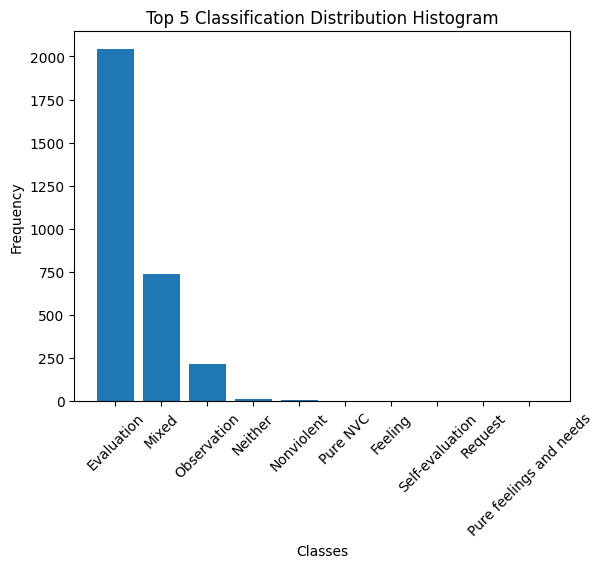

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram of the classification labels
unique_labels, label_counts = np.unique(df['classification'], return_counts=True)

# Sort the labels by count in descending order, and keep only top 10
sorted_indices = np.argsort(label_counts)[::-1]
top_labels = unique_labels[sorted_indices][:10]
top_counts = label_counts[sorted_indices][:10]

plt.bar(top_labels, top_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Top 5 Classification Distribution Histogram')
plt.xticks(rotation=45) #Rotate labels to prevent overlap
plt.show()

Mostly evaluations! That tracks as we asked Hermes to generate evaluations.

We only want to keep the samples classified as 'Evaluation' and 'Observation' samples

In [28]:
kept = df[(df['classification'] == 'Evaluation') | (df['classification'] == 'Observation')]

Let's look at our generations

In [29]:
def format_sample(sample):
    formatted = f'''Statement:“{sample['statement'].strip().lstrip("“").rstrip("”")}”
Reasoning: {sample['reasoning']}
Classification: {sample['classification']}'''

    if isinstance('pure_observation_alternative' in sample and sample['pure_observation_alternative'], str):
        formatted += '\n' + f"Pure observation alternative: “{sample['pure_observation_alternative'].strip().lstrip('“').rstrip('”')}”"

    return formatted

In [30]:
print(format_sample(df.sample(1).iloc[0]))

Statement:“I think it's ridiculous that we have to pretend to be someone else just to see an apartment.”
Reasoning: The statement contains evaluative language like "ridiculous" and "pretend to be someone else," which are judgments about the situation.
Classification: Evaluation
Pure observation alternative: “We had to wear suits and ties to see an apartment.”


Pretty good!

Let’s look at another one

In [31]:
print(format_sample(df.sample(1).iloc[0]))

Statement:“I think Stephanie is a great girl, but we just couldn't make it work between us.”
Reasoning: This statement includes a judgment about Stephanie's character (she's a "great girl") and a personal interpretation of the speaker's relationship with her (they ­"couldn't make it work").
Classification: Evaluation
Pure observation alternative: “I have a lot of respect for Stephanie, but we decided to end our relationship.”


Unfortunately, this one doesn't hit the mark as well. It feels distinctly artificial, lacking discernment and common sense.

We don't want that in our data. Let's add one final step to our pipeline: rating based filtering.

## Quality Control: Rating and Refining the Generated Statements

To evaluate the quality of our generations we can manually create ratings (with a rationale) for a few generations and use this as a few-shot prompt to rate all our samples.

In [32]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO', use_fast=True)

def evaluation_prompt(sample):
    return tokenizer.apply_chat_template(
        [
            {
                "role": "user",
                "content": """This is an exercise to learn some key principles of NVC as presented by Marshall B. Rosenberg

```
OBSERVATION OR EVALUATION?

In the context of Nonviolent Communication (NVC), it's crucial to distinguish between observations and evaluations. Observations are neutral descriptions of what one perceives, devoid of personal judgments or interpretations. In contrast, evaluations contain personal judgments or interpretations of situations. Your task is to review the provided statements and identify which ones are pure observations without any evaluations mixed in. By mastering this distinction, you can communicate more effectively, minimizing misunderstandings and conflicts.

To determine your proficiency at discerning between observations and evaluations, complete the following exercise.

Statement: “John was angry with me yesterday for no reason.”
Reasoning: The statement suggests that John felt a certain emotion (anger) directed towards the speaker and adds the qualifier "for no reason". Emotions are subjective experiences, and we can't definitively know someone's emotion unless they express it. The phrase "for no reason" is a judgment because it interprets the cause of John's perceived emotion.
Classification: Evaluation
Pure observation alternative: “John told me he was angry,” or “John pounded his fist on the table.”

Statement: “Yesterday evening Nancy bit her fingernails while watching television.”
Reasoning: This statement is simply describing an action Nancy did at a specific time. There is no attached judgment or interpretation of why she did it or what it means about her character or state of mind.
Classification: Observation

Statement: “Sam didn’t ask for my opinion during the meeting.”
Reasoning: This is a factual statement about something Sam did not do during a meeting. It doesn't assign any emotion, motive, or judgment to Sam's actions.
Classification: Observation
Statement: “My father is a good man.”
Reasoning: The term "good" is subjective. What constitutes a "good man" can vary from person to person. This statement is expressing a personal judgment or belief about the father's character rather than a factual observation.
Classification: Evaluation
Nonviolent alternative: “For the last twenty-five years, my father has given one-tenth of his salary to charity.”

Statement: “Janice works too much.”
Reasoning: The phrase "too much" is a judgment that implies there is an appropriate or normal amount of work, and Janice exceeds that. It's not a simple recounting of facts but an interpretation of her work habits.
Classification: Evaluation
Pure observation alternative: “Janice spent more than sixty hours at the office this week.”

Statement: “Henry is aggressive.”
Reasoning: Labeling Henry as "aggressive" is a judgment. "Aggressive" is an interpretive term that assigns a character trait to Henry based on behaviors or actions that aren't specified in this statement.
Classification: Evaluation
Pure observation alternative: “Henry hit his sister when she switched the television channel.”

Statement: “Pam was first in line every day this week.”
Reasoning: This statement simply states a repeated action Pam took on specific days. There's no interpretation about why she was first in line or what it might mean about her character.
Classification: Observation

Statement: “My son often doesn’t brush his teeth.”
Reasoning: The term "often" is a judgment that implies a frequency comparison to what is considered normal or acceptable. The statement isn't just stating times when the son didn't brush his teeth but is implying he neglects this action more than he should.
Classification: Evaluation
Pure observation alternative: “Twice this week my son didn’t brush his teeth before going to bed.”

Statement: “Luke told me I didn’t look good in yellow.”
Reasoning: This statement recounts a specific thing Luke said to the speaker. While Luke's statement was evaluative, the speaker is merely stating a fact about what Luke expressed, without adding their own judgment or interpretation.
Classification: Observation
```



We are trying to create a dataset of these statement classification to train an expert language model to learn to do this classification.

We have collected thousands of samples but they vary in quality. The text above text showcases the highest quality possible. Not all our collected samples have this quality. We aim to assess the quality of our samples. You will be tasked with looking at a sample and telling me what quality it is based on guidelines I will provide to you.


My guidelines come in the form of examples.

Good example 10/10
==================================
Statement:“I think it's ridiculous that we have to pretend to be someone else just to see an apartment.”
Reasoning: The statement contains evaluative language like "ridiculous" and "pretend to be someone else," which are judgments about the situation.
Classification: Evaluation
Pure observation alternative: “We had to wear suits and ties to see an apartment.”

Rating: Suggests an observation statement that does not tie identity to time bound clothing choices

Final judgment: Good sample because of clear example of evaluative language and good classification and reasoning + suggestion on the student's behalf
==================================


Okay-ish example 7/10
==================================
Statement:“I think Rose is too focused on the game and not paying enough attention to the road.”
Reasoning: This statement contains a judgment about Rose's level of focus and attention, which is subjective and not a factual observation.
Classification: Evaluation
Pure observation alternative: “Rose is playing a game on her phone while driving.”

Rating: The spirit is there but actually a driver being distracted and not paying enough attention to the road is a valid concern and not a simple evaluation

Final judgment: bad sample because of ambiguous statement
==================================


Good example 8/10
==================================
Statement:“I think it's ridiculous that Toni is so obsessed with his old high school hangout. It's like he's stuck in the past and can't move on.”
Reasoning: This statement includes several evaluations, such as "ridiculous," "obsessed," and "stuck in the past." These terms imply a negative judgment of Toni's behavior and mindset.
Classification: Evaluation
Pure observation alternative: “Toni has mentioned his high school hangout several times in the past week.”

Rating: The student correctly identified the use of evaluative language in the statement and provided a simple straight forward and not convoluted evaluation free observation

Final judgment: Good sample because of clear example statement
==================================


Okay-ish example 7/10
==================================
Statement:“I think Stacey really appreciates this new jacket I bought.”
Reasoning: The statement includes the phrase "I think," which implies the speaker is expressing their own interpretation or judgment about Stacey's feelings towards the jacket.
Classification: Evaluation
Pure observation alternative: “Stacey smiled and said ‘thank you’ when I gave her the jacket.”

Rating: While the observation is clearly a good observation statement, the first statement could be justified in context. For instance the speaker could have said prior facts about Stacey and the jacket

Final judgment: bad sample because of ambiguous statement
==================================


Good example 7.5/10
==================================
Statement:“I think Pacheco is always so focused on winning that he forgets to enjoy the game.”
Reasoning: This statement contains an evaluation of Pacheco's behavior. The speaker is interpreting Pacheco's focus on winning as a negative trait that prevents him from enjoying the game.
Classification: Evaluation
Pure observation alternative: “Pacheco has been practicing with the team every day for the past month.”

Rating: Good classification and reasoning on the student's practicing

Final judgment: Good sample because of classification, but statement could be clearer in a textbook setting
==================================


Bad example 4/10
==================================
Statement:“I think Stephanie is a great girl, but we just couldn't make it work between us.”
Reasoning: This statement includes a judgment about Stephanie's character (she's a "great girl") and a personal interpretation of the speaker's relationship with her (they "couldn't make it work").
Classification: Evaluation
Pure observation alternative: “I have a lot of respect for Stephanie, but we decided to end our relationship.”

Rating: Classification lacks nuance

Final judgment: Bad sample because of overly simplistic classification and reasoning and useless alternative suggestion
==================================






I will give you a sample and you will rate it as I thought you. Understood?"""
},
            {
                "content": "Understood. I will rate the given samples based on the guidelines you provided. Please provide me with the first sample to rate.",
                "role": "assistant",
            },
            {"content": sample, "role": "user"},
        ],
        tokenize=False,
        add_generation_prompt=True,
    ) + 'Rating:'

In [33]:
def create_ratings_table():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS hermes_ratings (
            id INTEGER PRIMARY KEY,
            sample TEXT,
            prompt TEXT,
            generation TEXT,
            generation_params json
        )
    ''')
    conn.commit()
    conn.close()

def insert_generated_rating(sample, prompt, generation, generation_params):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        INSERT INTO hermes_ratings (sample, prompt, generation, generation_params)
        VALUES (?, ?, ?, ?)
    ''', (sample, prompt, generation, json.dumps(generation_params)))
    conn.commit()
    conn.close()


def get_generated_evaluation_for_prompt(prompt):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        SELECT generation FROM hermes_ratings WHERE prompt = ?
    ''', (prompt,))
    result = c.fetchone()
    conn.close()
    return result[0] if result else None

def table_as_dataframe(table):
    conn = sqlite3.connect('results.sqlite')
    query = f'SELECT * FROM {table}'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

def generate_evaluation(sample, max_retries=10):
    generation_params = {
        "model": "NousResearch/Nous-Hermes-2-Mixtral-8x7B-DPO",
        "max_tokens": 512,
        "temperature": 0.7,
        "top_p": 0.7,
        "top_k": 50,
        "stop": [
            "<|im_end|>",
            "<|im_start|>"
        ],
        "repetition_penalty": 1,
    }

    prompt = evaluation_prompt(sample)
    
    existing_generation = get_generated_evaluation_for_prompt(prompt)

    if existing_generation is not None:
        print("Found existing generation for prompt")
        return None

    retries = 0
    while retries < max_retries:
        try:
            res = requests.post(ENDPOINT_URL, json={
                **generation_params,
                "prompt": prompt,
            }, headers={
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
            })

            if res.status_code == 200:
                return sample, prompt, res.json()['choices'][0]['text'], generation_params
            else:
                error_message = res.text
                print(f"Attempt {retries + 1} failed with status code {res.status_code}. Error: {error_message}. Retrying...")
        except requests.exceptions.RequestException as e:
            print(f"An error occurred: {e}. Retrying...")

        retries += 1
        time.sleep(1)  # Sleep for a bit before retrying to avoid overwhelming the server

    return None



create_ratings_table()

arguments_list = [format_sample(kept.iloc[i].to_dict()) for i in range(len(kept))]
generator = Generator(max_workers=20, generate_function=generate_evaluation, arguments_list=arguments_list)

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        sample, prompt, generation, generation_params = result
        insert_generated_rating(sample, prompt, generation, generation_params)

  100%|█████████████████████████████████████████████████████████████████████████████████████| 3023/3023 [00:00<?, ?it/s]

In [34]:
df = table_as_dataframe('hermes_ratings')

In [35]:
df[['sample', 'generation']].head(5)

,sample,generation
0,"Statement:“Jerry, you're making a big deal out of nothing. Just call Stephanie and ask her where she's staying. If she doesn't want to tell you, she'll make it clear. Stop overthinking things and just be straightforward.”\nReasoning: This statement contains several evaluations. ""Making a big deal out of nothing"" and ""overthinking things"" are judgments about Jerry's behavior. The phrase ""just be straightforward"" implies that Jerry's current approach is not straightforward enough.\nClassification: Evaluation\nPure observation alternative: “Jerry, you seem worried about where Stephanie is staying. You've been asking me and others about it for the past few days. I'm not sure where she's staying, but you could try calling her and asking directly.”","8/10\n\nFinal judgment: Good sample because of clear example of evaluative language and good classification and reasoning + suggestion on the student's behalf. The student could have mentioned the specific phrases that are evaluative, such as ""making a big deal out of nothing"" and ""overthinking things,"" but overall, the example is clear and well-explained."
1,"Statement:“Men have been trying their best to understand women, but it seems like we're still struggling. It's frustrating to see women reading articles about where to meet men when we're already everywhere, honking our horns to serve them better.”\nReasoning: This statement contains several evaluations like ""trying their best,"" ""still struggling,"" ""frustrating,"" and ""serving them better."" These are subjective judgments about men's efforts to understand women and the frustration women may feel.\nClassification: Evaluation\nPure observation alternative: “I read an article in a women’s magazine that said men don’t understand women.”",The student correctly identified the use of evaluative language in the statement and provided a simple straight forward and not convoluted evaluation free observation.\nFinal judgment: Good sample because of clear example statement
2,Statement:“Performing on stage is one of the most exhilarating experiences I've ever had.”\nReasoning: This statement expresses a personal feeling or emotion about an experience. It doesn't contain any judgments or interpretations about the experience itself or the reasons for the feeling.\nClassification: Observation,"5/10\n\nFinal judgment: Bad sample because of overly simplistic classification and reasoning and useless alternative suggestion. The statement is not evaluative, but it's also not a pure observation as it contains a personal feeling or emotion about an experience. A better classification would be a mix of observation and evaluation. A possible alternative observation statement could be: ""I have performed on stage multiple times."""
3,Statement:“Vanessa is the most captivating woman I've ever met.”\nReasoning: The statement contains a judgment about Vanessa's qualities and a comparison to other women the speaker has met. It's not just a factual description of what the speaker observed about Vanessa but an interpretation of her qualities in relation to others.\nClassification: Evaluation\nPure observation alternative: “Vanessa has a warm smile and a charming laugh.”,The student correctly identified the use of evaluative language in the statement and provided a simple straight forward and not convoluted evaluation free observation.\nFinal judgment: Good sample because of clear example statement.
4,"Statement:“You're always barging in unannounced and making a mess. It's really inconsiderate.”\nReasoning: This statement includes several evaluations, including ""always,"" ""inconsiderate,"" and ""making a mess."" It also includes an interpretation of the speaker's actions as ""barging in unannounced.""\nClassification: Evaluation\nPure observation alternative: “I noticed you entered my room without knocking and left dirty dishes on the table.”",Good classification and reasoning on the student's behalf\n\nFinal judgment: Good

Looks good to me.  

Let's now filter for the samples rated as "Good".

In [36]:
good = [sample for sample, evaluation in zip(df['sample'].to_list(), df['generation'].to_list()) if 'Final judgment: Good' in evaluation]

good_samples = [extract_all_fields(sample) for sample in good if len(extract_all_fields(sample).keys()) == 4] # Let's also keep only the samples that have all the four fields we want to parse

Now that we've filtered for quality, let's plot the class distribution again.

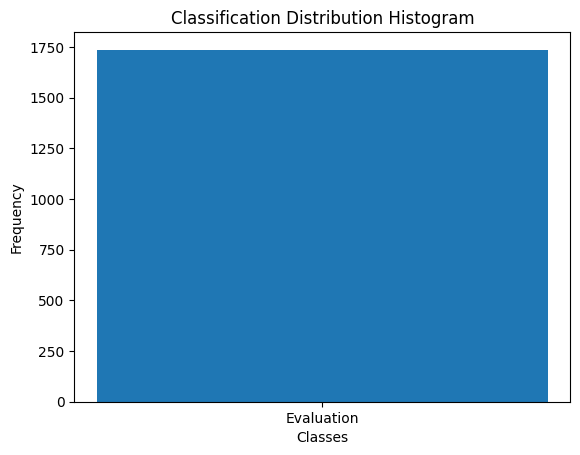

In [37]:
import matplotlib.pyplot as plt
import numpy as np

classes = [sample['classification'] for sample in good_samples]
classification_labels = [label for label in classes if label is not None]

# Create a histogram of the classification labels
unique_labels, label_counts = np.unique(classification_labels, return_counts=True)

# Plot the histogram
plt.bar(unique_labels, label_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Classification Distribution Histogram')
plt.show()

We only have one class represented in our dataset! Let’s fix that.

## Balancing the dataset

You might have noticed that every statement comes with a generated "Pure observation alternative". Let's take 50% of our samples and switch the main statement to the observation alternative, then generate a new rationale and classification with this.

In [38]:
import random

# randomly select 50% of the samples to be observations
observations = [sample['pure_observation_alternative'].strip('“').rstrip('”') for sample in random.sample(good_samples, int(len(good_samples)/2))]

Now we generate the new rationales and classifications for the swapped statements

In [39]:
def create_swapped_classifications_table():
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        CREATE TABLE IF NOT EXISTS swapped_classifications (
            id INTEGER PRIMARY KEY,
            statement TEXT,
            prompt TEXT,
            generation TEXT,
            generation_params json
        )
    ''')
    conn.commit()
    conn.close()

def insert_generated_classification(statement, prompt, generation, generation_params):
    conn = sqlite3.connect('results.sqlite')
    c = conn.cursor()
    c.execute('''
        INSERT INTO swapped_classifications (statement, prompt, generation, generation_params)
        VALUES (?, ?, ?, ?)
    ''', (statement, prompt, generation, json.dumps(generation_params)))
    conn.commit()
    conn.close()

def table_as_dataframe(table):
    conn = sqlite3.connect('results.sqlite')
    query = f'SELECT * FROM {table}'
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

create_swapped_classifications_table()

arguments_list = observations
generator = Generator(max_workers=20, generate_function=generate_classification, arguments_list=arguments_list)

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        statement, prompt, generation, generation_params = result
        insert_generated_classification(statement, prompt, generation, generation_params)

   100%|█████████████████████████████████████████████████████████████████████████████████████| 868/868 [00:00<?, ?it/s]

For good measure let's keep only the new samples reclassified as Observations

In [40]:
statements = fetch_column('swapped_classifications', 'statement')
generations = fetch_column('swapped_classifications', 'generation')

swapped = [sample for sample in [extract_all_fields('Statement: ' + statements[i] + '\n' + gen) for i, gen in enumerate(generations)] if sample['classification'] == 'Observation']

Let's filter yet again for good classifications

In [41]:
arguments_list = [format_sample(sample) for sample in swapped]
generator = Generator(max_workers=20, generate_function=generate_evaluation, arguments_list=arguments_list)

for result in tqdm(generator, total=len(arguments_list)):
    if result is not None:
        sample, prompt, generation, generation_params = result
        insert_generated_rating(sample, prompt, generation, generation_params)

  100%|█████████████████████████████████████████████████████████████████████████████████████| 684/684 [00:00<?, ?it/s]

In [42]:
def fetch_rating_from_sample(sample):
    conn = sqlite3.connect('results.sqlite')
    cursor = conn.cursor()
    
    query = "SELECT generation FROM hermes_ratings WHERE sample = ?"
    
    cursor.execute(query, (sample,))
    
    # Fetch the result
    result = cursor.fetchone()
    
    # Close the connection
    conn.close()
    
    # Check if the result is not None and return the value of column D
    if result:
        return result[0]
    else:
        return None



kept_swapped = [sample for sample in swapped if 'Final judgment: Good' in fetch_rating_from_sample(format_sample(sample))]

In [43]:
intact_samples = [sample for sample in good_samples if sample['pure_observation_alternative'].strip('“').rstrip('”') not in observations]

In [44]:
len(kept_swapped)

579

In [45]:
len(originals)

869

In [46]:
len(intact_samples + kept_swapped)

1448

In [47]:
final = intact_samples + kept_swapped

We can now plot the new distribution

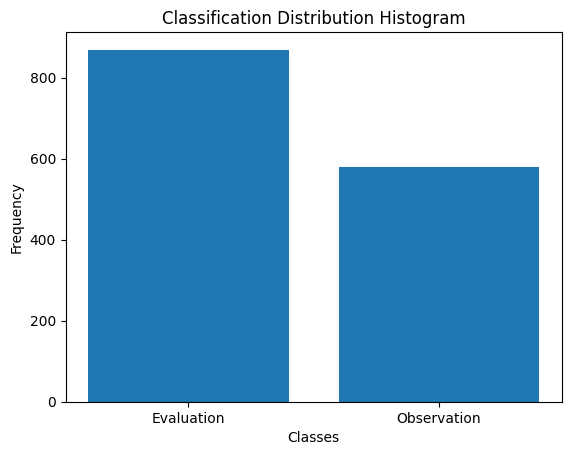

In [48]:
import matplotlib.pyplot as plt
import numpy as np

statements = fetch_column('swapped_classifications', 'statement')
generations = fetch_column('swapped_classifications', 'generation')

classes = [sample['classification'] for sample in final]
classification_labels = [label for label in classes if label is not None]

# Create a histogram of the classification labels
unique_labels, label_counts = np.unique(classification_labels, return_counts=True)

# Plot the histogram
plt.bar(unique_labels, label_counts)
plt.xlabel('Classes')
plt.ylabel('Frequency')
plt.title('Classification Distribution Histogram')
plt.show()

Looks better  

And with that we are done!

Let's save the raw prompts, generated content, and associated parameters as CSV to include in the repo

In [49]:
def get_generations_data(table):
    conn = sqlite3.connect('results.sqlite')
    cursor = conn.cursor()
    
    query = f"SELECT prompt, generation, generation_params FROM {table}"
    
    cursor.execute(query)
    
    results = cursor.fetchall()
    conn.close()

    if len(results) > 0:
        return [{'formatted_prompt' : prompt, 'generation' : generation, 'generation_params' : generation_params } for prompt, generation, generation_params in results]

    return None


generations = get_generations_data('statement_generation') + get_generations_data('swapped_classifications') + get_generations_data('scene_statements') + get_generations_data('statement_generation') + get_generations_data('clean_statements') + get_generations_data('llama_classifications') + get_generations_data('hermes_ratings') + get_generations_data('swapped_classifications')
pd.DataFrame(generations).to_csv('generations.csv', index=False)

## The Final Step: Pushing to Hugging Face hub

Let’s push to the hub

In [50]:
!pip install huggingface_hub

In [51]:
from huggingface_hub import notebook_login

notebook_login()

In [52]:
from datasets import Dataset, DatasetDict
import pandas as pd

final_df = pd.DataFrame(final)

shuffled_df = final_df.sample(frac=1).reset_index(drop=True) # Shuffle because right now the evaluations are all together and the observations all together
test_set = Dataset.from_pandas(shuffled_df) #we use pandas we need to load a list of dicts and not a dicts of list

# we put in test set as it not is not meant to be trained on
dataset = DatasetDict({
    'test': test_set, 
})


dataset.push_to_hub("thomasgauthier/observation_or_evaluation")

Uploading the dataset shards:   0%|██████████████████████████████████████████| 1/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|██████████████████████████████████████████| 2/2 [00:00<?, ?ba/s]